In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pickle
import random as rnd
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns
import sklearn
import statsmodels.api as sm
import xgboost as xgb
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.widgets import RunDetails
from matplotlib import pyplot
from matplotlib.font_manager import FontProperties
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              ExtraTreesClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, VotingClassifier)
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                       VarianceThreshold, chi2)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import (LinearRegression, LogisticRegression, PassiveAggressiveClassifier,
                                  Perceptron, RidgeClassifier, SGDClassifier)
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix, log_loss,
                             precision_score, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     cross_val_score, train_test_split)
from sklearn.naive_bayes import (BernoulliNB, ComplementNB, GaussianNB,
                                 MultinomialNB)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (Binarizer, LabelEncoder, MinMaxScaler,
                                   Normalizer, OneHotEncoder,
                                   PolynomialFeatures, StandardScaler,
                                   normalize)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
traindf = pd.read_csv('../data/train.csv', index_col="ID")
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
84521,City Hotel,0,0,2017,February,7,16,0,1,1,0.0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NaN,45.0,0,Transient,1.420560,0,1,Check-Out,2017-02-17
66180,City Hotel,0,181,2016,October,42,11,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,234.0,NaN,0,Transient-Party,103.953569,0,0,Check-Out,2016-10-13


### Drop columns not in test data and Clean missing data
* Drop columns: `adr`, `reservation_status`, `reservation_status_date`

In [4]:
testCol = set(pd.read_csv('../data/test.csv', index_col="ID").columns)
removeCols = [col for col in traindf.columns if col not in testCol]
removeCols.remove("is_canceled")
print(removeCols)

['adr', 'reservation_status', 'reservation_status_date']


In [5]:
traindf = traindf.drop(removeCols, axis=1)
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2818,Resort Hotel,1,10,2015,August,31,1,0,1,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,F,F,0,No Deposit,NaN,NaN,0,Transient-Party,0,0
20838,Resort Hotel,0,210,2015,December,52,21,2,5,2,0.0,0,HB,GBR,Offline TA/TO,TA/TO,0,0,0,E,E,0,No Deposit,314.0,NaN,0,Contract,0,1


The below code shows column name of missing data

In [6]:
tmp = pd.to_numeric((traindf.isnull().sum() / traindf.shape[0]).map('{:,.2f}'.format))
tmp[tmp > 0]

country    0.01
agent      0.14
company    0.94
dtype: float64

* The company feature's 94% is missing. Because of that, this feature will be eliminated. 
* Another missing data has occurred in country and agent features. Since missing data of country is less than 1%, these data will replace with most frequent value. 
* However, the agent missing features are more than the country. For this feature, missing data will be imputed as 0

In [7]:
traindf["children"] = traindf["children"].fillna(0)
traindf["country"] = traindf["country"].fillna(traindf["country"].mode().index[0])
traindf["agent"] = traindf["agent"].fillna("0")
traindf = traindf.drop(["company"], axis=1)

In [8]:
traindf.sample(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
67867,Resort Hotel,1,23,2016,October,43,19,0,3,2,2.0,0,BB,FRA,Online TA,TA/TO,0,0,0,G,G,0,No Deposit,240,0,Transient,0,1
27483,City Hotel,1,24,2016,February,9,26,1,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,0,Transient,0,1
50876,Resort Hotel,0,217,2016,July,29,12,1,5,2,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,A,E,0,No Deposit,240,0,Transient,0,1
10671,City Hotel,0,86,2015,September,39,24,0,2,2,0.0,0,BB,FRA,Offline TA/TO,TA/TO,0,0,0,A,B,0,No Deposit,12,0,Transient-Party,0,0
34850,City Hotel,0,47,2016,April,16,12,0,4,2,0.0,0,BB,CHE,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,0,Transient,0,1


### Feature Transformation

`date`: Combine `arrival_date_year`, `arrival_date_month`, `arrival_date_week_number` to date object
<br>One hot encoding `arrival_date_month`

In [9]:
# def create_date(year: pd.Series, month: pd.Series, date: pd.Series) -> pd.Series:
#     return pd.to_datetime(year.astype(str) + month + date.astype(str), format="%Y%B%d")

# traindf.insert(loc=0, column="date", 
#           value=create_date(traindf["arrival_date_year"], traindf["arrival_date_month"], traindf["arrival_date_day_of_month"]))
# traindf = traindf.drop(["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"], axis=1)

month = pd.get_dummies(traindf.arrival_date_month)
traindf = pd.concat([traindf, month], axis=1, join="inner")
traindf = traindf.drop(["arrival_date_month"], axis=1)

`hotel`: Convert hotel as `Resort Hotel` to 0, `City Hotel` to 1

In [10]:
traindf["hotel"] = traindf["hotel"].map({"Resort Hotel": 0, "City Hotel": 1})

Create new feature `is_same_room`: Check if `reserved_room_type` is same as `assigned_room_type`(If so 1, else 0)
<br>One hot encoding `reserved_room_type` and `assigned_room_type`

In [11]:
traindf["is_same_room"] = (traindf["reserved_room_type"] == traindf["assigned_room_type"]).map({True: 1, False: 0})
reserved = pd.get_dummies(traindf.reserved_room_type, prefix="reserved_")
assigned = pd.get_dummies(traindf.assigned_room_type, prefix="assigned_")
traindf = pd.concat([traindf, reserved, assigned], axis=1, join="inner")
traindf = traindf.drop(["reserved_room_type", "assigned_room_type"], axis=1)

`children`: `children` + `babies`

In [12]:
traindf["children"] = traindf["children"] + traindf["babies"]
traindf = traindf.drop(["babies"], axis=1)

One hot encoding: `meal`

In [13]:
meal = pd.get_dummies(traindf.meal, prefix="meal_")
traindf = pd.concat([traindf, meal], axis=1, join="inner")
traindf = traindf.drop(["meal"], axis=1)

Classify `country` to `proneToCancel`, `neutralToCancel`, `notProneToCancel` based on canceled rate
* `proneToCancel`: canceled rate >= 0.5
* `neutralToCancel`: 0.3 < canceled rate < 0.5
* `notProneToCancel`: canceled rate <= 0.3

In [14]:
def country_cancel_tendency(traindf):
    tmp = traindf[["country", "is_canceled"]].groupby("country").agg({'country': 'count', 'is_canceled': 'mean'})
    proneToCancel = set(tmp[tmp.is_canceled > 0.5]["country"].index)
    neutralToCancel = set(tmp[(tmp.is_canceled <= 0.5) & (tmp.is_canceled > 0.3)]["country"].index)
    notProneToCancel = set(tmp[tmp.is_canceled <= 0.3]["country"].index)
    
    traindf["countryProneToCancel"] = traindf["country"].apply(lambda x: 1 if x in proneToCancel else 0)
    traindf["countryNeutralToCancel"] = traindf["country"].apply(lambda x: 1 if x in neutralToCancel else 0)
    traindf["countryNotProneToCancel"] = traindf["country"].apply(lambda x: 1 if x in notProneToCancel else 0)
    traindf = traindf.drop(["country"], axis=1)
    
    return traindf

traindf = country_cancel_tendency(traindf)

In [15]:
traindf.sample(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,April,August,December,February,January,July,June,March,May,November,October,September,is_same_room,reserved__A,reserved__B,reserved__C,reserved__D,reserved__E,reserved__F,reserved__G,reserved__H,reserved__L,reserved__P,assigned__A,assigned__B,assigned__C,assigned__D,assigned__E,assigned__F,assigned__G,assigned__H,assigned__I,assigned__K,assigned__L,assigned__P,meal__BB,meal__FB,meal__HB,meal__SC,meal__Undefined,countryProneToCancel,countryNeutralToCancel,countryNotProneToCancel
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18832,1,1,25,2015,48,27,2,5,2,0.0,Online TA,TA/TO,0,1,0,0,No Deposit,9,0,Contract,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
14851,1,0,221,2015,42,17,2,1,2,0.0,Offline TA/TO,TA/TO,0,0,0,0,No Deposit,3,0,Transient-Party,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


Classify `agent` to `agentProneToCancel`, `agentNeutralToCancel`, `agentNotProneToCancel` based on canceled rate
* `agentLikelyToCancel`: canceled rate > 0.75
* `agentProneToCancel`: 0.5 < canceled rate <= 0.75
* `agentNeutralToCancel`: 0.3 < canceled rate <= 0.5
* `agentNotProneToCancel`: canceled rate <= 0.3

In [16]:
def agent_cancel_tendency(traindf):
    tmp = traindf[["agent", "is_canceled"]].groupby("agent").agg({'agent': 'count', 'is_canceled': 'mean'})
    likelyToCancel = set(tmp[tmp.is_canceled > 0.75]["agent"].index)
    proneToCancel = set(tmp[(tmp.is_canceled <= 0.75) & (tmp.is_canceled > 0.5)]["agent"].index)
    neutralToCancel = set(tmp[(tmp.is_canceled <= 0.5) & (tmp.is_canceled > 0.3)]["agent"].index)
    notProneToCancel = set(tmp[tmp.is_canceled <= 0.3]["agent"].index)
    
    traindf["agentLikelyToCancel"] = traindf["agent"].apply(lambda x: 1 if x in likelyToCancel else 0)
    traindf["agentProneToCancel"] = traindf["agent"].apply(lambda x: 1 if x in proneToCancel else 0)
    traindf["agentNeutralToCancel"] = traindf["agent"].apply(lambda x: 1 if x in neutralToCancel else 0)
    traindf["agentNotProneToCancel"] = traindf["agent"].apply(lambda x: 1 if x in notProneToCancel else 0)
    traindf = traindf.drop(["agent"], axis=1)
    
    return traindf

traindf = agent_cancel_tendency(traindf)

### Train Model and Evaluate best model performance

In [17]:
traindf = pd.get_dummies(traindf)
new_train_x = traindf.drop("is_canceled", axis=1).values
new_train_y = traindf["is_canceled"].values

In [18]:
classifiers = [XGBClassifier(),
               ExtraTreesClassifier(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               RidgeClassifier(),
               QuadraticDiscriminantAnalysis(),
               ComplementNB(),
               BernoulliNB(),
               GaussianNB(),
               MultinomialNB(),
               LinearDiscriminantAnalysis(),
               SGDClassifier(),
               AdaBoostClassifier(),
               BaggingClassifier(),
               LogisticRegression(),
               LinearSVC(),
               KNeighborsClassifier()
               ]

from time import time

for clf in classifiers:
    
    before = time()
    print("="*30)
    print(clf.__class__.__name__)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    crossValScore = cross_val_score(clf, new_train_x, new_train_y, scoring='balanced_accuracy', cv=skf)  
    crossValScore_mean = np.mean(crossValScore) 
    print("Stratified Cross Validation Score, balanced_accuracy: {:.4}".format(crossValScore_mean))
    after = time()
    print(f"花費{(after - before):.1f}s")
    
print("="*30)

PassiveAggressiveClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.6525
花費15.2s
XGBClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.8486
花費52.1s
ExtraTreesClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.883
花費39.0s
DecisionTreeClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.8644
花費3.3s
RandomForestClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.8895
花費34.2s
RidgeClassifier
Stratified Cross Validation Score, balanced_accuracy: 0.7712
花費1.0s
QuadraticDiscriminantAnalysis
Stratified Cross Validation Score, balanced_accuracy: 0.6923
花費2.4s
ComplementNB
Stratified Cross Validation Score, balanced_accuracy: 0.6322
花費0.6s
BernoulliNB
Stratified Cross Validation Score, balanced_accuracy: 0.7456
花費0.8s
GaussianNB
Stratified Cross Validation Score, balanced_accuracy: 0.7128
花費0.7s
MultinomialNB
Stratified Cross Validation Score, balanced_accuracy: 0.6316
花費0.5s
LinearDiscriminantAnalysis
Stratified Cross 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(new_train_x, new_train_y, test_size=0.3)
clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     17534
           1       0.90      0.83      0.86      9926

    accuracy                           0.90     27460
   macro avg       0.90      0.89      0.89     27460
weighted avg       0.90      0.90      0.90     27460



### Feature Importance

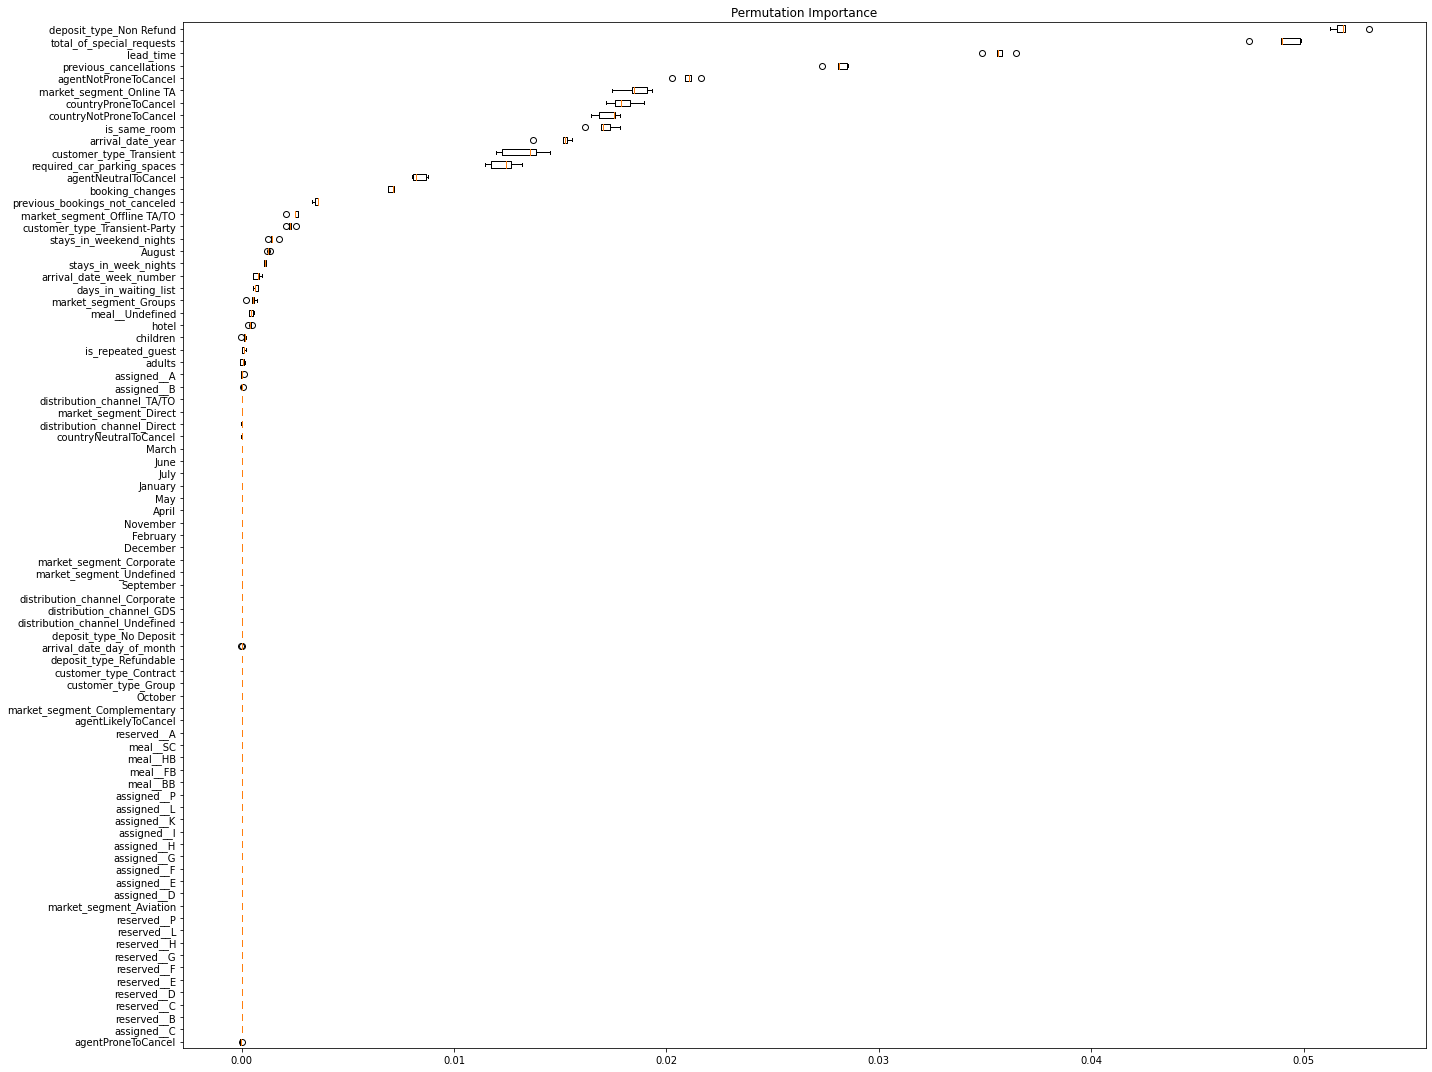

In [34]:
model = XGBClassifier()
model = model.fit(X_train, y_train)
result = permutation_importance(model, X_train, y_train, scoring="accuracy", n_repeats=5, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(20, 15))

ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=traindf.drop("is_canceled", axis=1).columns[sorted_idx])
ax.set_title("Permutation Importance")
fig.tight_layout()
plt.show()

### Dump model for future usage

In [21]:
import pickle

with open("cancel.pkl", "wb+") as file:
    pickle.dump(clf, file)